In [1]:
# Loading in the data from Geisel Library

import pandas as pd
import os
import glob

# Specify the path to your CSV files
path = r'C:\ResearchFiles\AllFiles_Cleaned\Geisel_Library'
all_files = glob.glob(os.path.join(path, "*.csv"))

# Combine all files into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['smart_plug_id'] = os.path.basename(filename).split('_')[1]  # Add a column for the smart plug identifier
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [2]:
# Drop unneccessary columns
combined_df = combined_df.drop(columns = ['analogInput_2', 'analogInput_4', 'analogInput_5', 'binaryInput_3', 'binaryValue_1'])

# Convert timestamp column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Set timestamp as index and rename the poewr consumption column for better readability
combined_df.set_index('time', inplace=True)
combined_df = combined_df.rename(columns = {'analogInput_3': 'power_consumption (mW)'})

In [3]:
combined_df

,power_consumption (mW),smart_plug_id
time,,
2023-09-15 17:25:00,9006.0,180440
2023-09-15 17:26:00,8778.0,180440
2023-09-15 17:27:00,9006.0,180440
2023-09-15 17:28:00,8855.0,180440
2023-09-15 17:29:00,8588.0,180440
...,...,...
2024-06-10 23:55:00,16008.0,656672
2024-06-10 23:56:00,16008.0,656672
2024-06-10 23:57:00,16008.0,656672


In [4]:
# Forward fill any missing values
combined_df.fillna(method='ffill', inplace=True)

In [5]:
# Resample to daily intervals for easier graphing abilities
daily_df = combined_df.resample('D').mean(numeric_only=True)

In [6]:
# Convert all power consumption values from milliWatt to KW/h and rename appropriately
daily_df['power_consumption (mW)'] = daily_df['power_consumption (mW)'] / 1_000_000
daily_df.rename(columns = {'power_consumption (mW)': 'power_consumption (KW)'}, inplace=True)

In [7]:
daily_df

,power_consumption (KW)
time,
2023-09-14,0.029076
2023-09-15,0.023824
2023-09-16,NaN
2023-09-17,NaN
2023-09-18,NaN
...,...
2024-06-06,0.029777
2024-06-07,0.028458
2024-06-08,0.026224


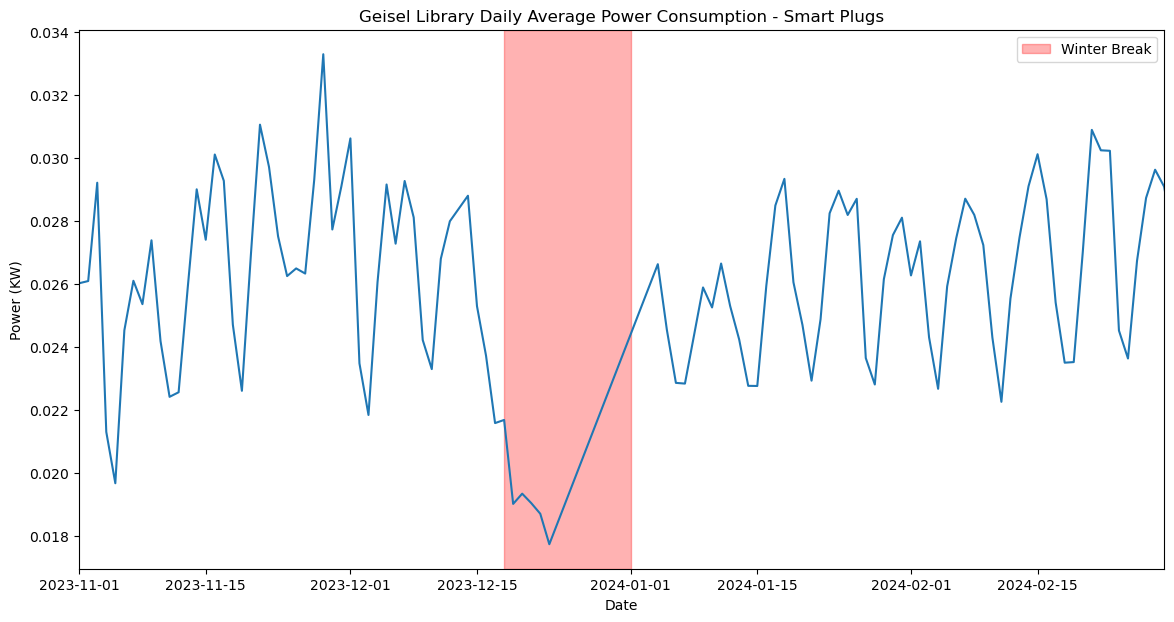

In [8]:
# Creating a graph that overlays winter break with the time series data to show the dip in power consumption during this period

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the date range to show in the plot
start_date = '2023-11-01'
end_date = '2024-02-29'

# Define the winter break date range
winter_break_start = '2023-12-18'
winter_break_end = '2024-01-01'

# Plotting overall trends
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=daily_df, x=daily_df.index, y='power_consumption (KW)')
plt.title('Geisel Library Daily Average Power Consumption - Smart Plugs')
plt.xlabel('Date')
plt.ylabel('Power (KW)')

# Highlight the winter break period with a different color (e.g., light blue)
plt.axvspan(pd.to_datetime(winter_break_start), pd.to_datetime(winter_break_end), color='red', alpha=0.3, label='Winter Break')

# Set the x-axis limits
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Show the legend
plt.legend()

plt.show()

In [9]:
# Read in the csv file containing the metering data we have on EBU3B and Atkinson Hall
building_metering = pd.read_csv(r'C:\Users\vaugh\Downloads\building_metering.csv')

# Drop unneccessary columns so that we're just left with the timestamp and total energy consumption from EBU3B
building_metering = building_metering.drop(columns = ['WARREN.CAL_IT_E2531#Real Power Mean#kW', 'WARREN.CAL_IT_E2532#Real Power Mean#kW', 'WARREN.CAL_IT_Gate_E2530#Real Power Mean#kW', 'WARREN.EBU3B_E2520#Real Power Mean#kW', 'WARREN.EBU3B_E2521#Real Power Mean#kW'])

# Convert timestamp column to datetime
building_metering['Timestamp'] = pd.to_datetime(building_metering['Timestamp'])

In [10]:
# Adjusting both power totals from KW to KW/h
building_metering['EBU3B total'] = building_metering['EBU3B total']
building_metering['Atkinson total'] = building_metering['Atkinson total']

# Creating a new column to get sum of the consumption from each building
building_metering['Both Buildings total'] = building_metering['EBU3B total'] + building_metering['Atkinson total']

# Set 'Timestamp' as the index
building_metering.set_index('Timestamp', inplace=True)

In [11]:
building_metering

,EBU3B total,Atkinson total,Both Buildings total
Timestamp,,,
2023-01-01 00:15:00,312.613174,632.773163,945.386337
2023-01-01 00:30:00,313.511780,630.595501,944.107281
2023-01-01 00:45:00,317.042526,631.453430,948.495956
2023-01-01 01:00:00,318.071701,627.231457,945.303158
2023-01-01 01:15:00,316.035248,634.164612,950.199860
...,...,...,...
2024-07-21 23:30:00,397.910767,670.800072,1068.710838
2024-07-21 23:45:00,396.301117,667.563164,1063.864281
2024-07-22 00:00:00,394.709076,666.877243,1061.586319


In [12]:
# Resample to daily intervals for easier graphing abilities
metering_daily_df = building_metering.resample('D').mean(numeric_only=True)

In [13]:
metering_daily_df

,EBU3B total,Atkinson total,Both Buildings total
Timestamp,,,
2023-01-01,313.023348,644.811766,957.835115
2023-01-02,317.096762,653.045333,970.142095
2023-01-03,323.047844,669.506889,992.554733
2023-01-04,329.164759,679.844078,1009.008836
2023-01-05,327.075034,671.032337,998.107371
...,...,...,...
2024-07-18,394.555484,714.119269,1108.674753
2024-07-19,408.059048,708.458708,1116.517757
2024-07-20,405.051615,687.572326,1092.623941


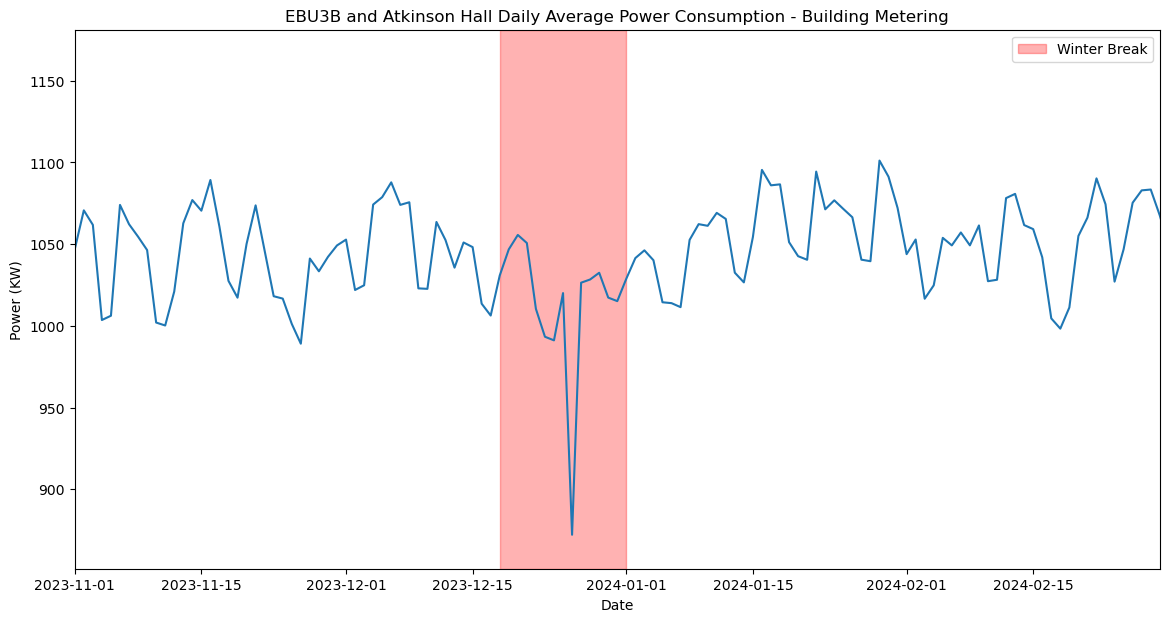

In [14]:
# Plotting overall trends
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=metering_daily_df, x=metering_daily_df.index, y='Both Buildings total')
plt.title('EBU3B and Atkinson Hall Daily Average Power Consumption - Building Metering')
plt.xlabel('Date')
plt.ylabel('Power (KW)')

# Highlight the winter break period with a different color (e.g., light blue)
plt.axvspan(pd.to_datetime(winter_break_start), pd.to_datetime(winter_break_end), color='red', alpha=0.3, label='Winter Break')

# Set the x-axis limits
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# Show the legend
plt.legend()

plt.show()